In [11]:
from dotenv import load_dotenv
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_core.tools import tool
from langgraph.graph import StateGraph, START
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_groq import ChatGroq
import os 
from langchain_community.embeddings import HuggingFaceEmbeddings


In [12]:
load_dotenv()

True

In [13]:
llm = ChatGroq(
    groq_api_key=os.getenv("GROQ_API_KEY"),
    model_name="openai/gpt-oss-120b"
)


In [14]:
loader = PyPDFLoader("D:\Semister-5\ML\Theory\Linear_Regression (BIG).pdf")
docs = loader.load()
len(docs)

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\Admin\AppData\Local\Temp\ipykernel_14476\3010279326.py:1: SyntaxWarning: invalid escape sequence '\S'
  loader = PyPDFLoader("D:\Semister-5\ML\Theory\Linear_Regression (BIG).pdf")


105

In [15]:
splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)
len(chunks)

94

In [29]:
embeddings = HuggingFaceEmbeddings(model_name="text-embedding-3-small")
vector_store = FAISS.from_documents(chunks, embeddings)

No sentence-transformers model found with name sentence-transformers/text-embedding-3-small. Creating a new one with mean pooling.


OSError: sentence-transformers/text-embedding-3-small is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`

In [27]:
retriever = vector_store.as_retriever(search_type='similarity', search_kwargs={'k':4})

NameError: name 'vector_store' is not defined

In [18]:
@tool
def rag_tool(query):

    """
    Retrieve relevant information from the pdf document.
    Use this tool when the user asks factual / conceptual questions
    that might be answered from the stored documents.
    """
    result = retriever.invoke(query)

    context = [doc.page_content for doc in result]
    metadata = [doc.metadata for doc in result]

    return {
        'query': query,
        'context': context,
        'metadata': metadata
    }

In [19]:
tools = [rag_tool]
llm_with_tools = llm.bind_tools(tools)

In [20]:
class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]

In [22]:
def chat_node(state: ChatState):

    messages = state['messages']

    response = llm_with_tools.invoke(messages)

    return {'messages': [response]}


tool_node = ToolNode(tools)

In [23]:
graph = StateGraph(ChatState)

graph.add_node('chat_node', chat_node)
graph.add_node('tools', tool_node)

graph.add_edge(START, 'chat_node')
graph.add_conditional_edges('chat_node', tools_condition)
graph.add_edge('tools', 'chat_node')

chatbot = graph.compile()

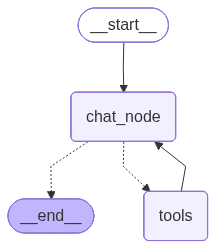

In [24]:
chatbot

In [28]:
result = chatbot.invoke(
    {
        "messages": [
            HumanMessage(
                content=(
                    "Using the pdf notes, explain how to find the ideal value of K in KNN"
                )
            )
        ]
    }
)

NameError: name 'retriever' is not defined

In [ ]:
print(result['messages'][-1].content)